# ✋ Hand Sign Images with CNN

## 📊 About the Dataset

This project uses the **Sign Language MNIST** dataset in the form of JPEG images.  
The task is a **multi-class classification problem** with **24 hand sign classes** representing the American Sign Language (ASL) alphabet, excluding **J** and **Z** (since they require motion).

### 🔹 Dataset Details
- **Total Images:** 34,627 (Train: 27,455 | Test: 7,172)
- **Image Format:** Grayscale JPEG  
- **Image Size:** 28 × 28 pixels  
- **Value Range:** 0 – 255  
- **Classes:** 24 (A–Y, excluding J and Z)  
- **Labels:** Each folder is named after the class it contains.  

### 🔹 Data Preparation
The dataset was derived from the Sign Language MNIST CSV version and converted into images.  
Processing steps included:  
- Cropping around the hand region.  
- Grayscale conversion.  
- Resizing to 28×28 pixels.  
- Data augmentation using:
  - Rescaling
  - Flipping
  - Random pixelation.  
  - Small rotations.  

### 🔹 Why This Dataset?
- It provides a balanced, pre-structured dataset suitable for training CNNs.  
- Each class has multiple variations to improve generalization.  
- Compatible with TensorFlow/Keras `ImageDataGenerator` for easy loading and augmentation.  

---


In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ash2703_handsignimages_path = kagglehub.dataset_download('ash2703/handsignimages')

print('Data source import complete.')

100%|██████████| 23.1M/23.1M [00:00<00:00, 133MB/s] 

Extracting files...


Data source import complete.


## 📌 Environment Setup and Basic Imports

In this cell, we import the fundamental Python libraries and set up the environment.  
- **NumPy**: For numerical operations and linear algebra.  
- **Pandas**: For data manipulation and handling CSV files.  
- **OS**: To interact with the file system (used here to check input files).  

This ensures that our environment is ready for data loading and further processing.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
train_path = '/kaggle/input/handsignimages/Train'
test_path = '/kaggle/input/handsignimages/Test'

## 📌 Preparing Training Data

We use `ImageDataGenerator` to preprocess and augment training images:  
- **Rescaling**: Normalize pixel values from `[0, 255]` to `[0, 1]`.  
- **Rotation & Zoom**: To make the model more robust to variations.  
- **Horizontal Flip**: Helps generalize better by flipping images.  

Finally, `flow_from_directory` loads the images from the training folder into batches with one-hot encoded labels.


In [ ]:
# defining train data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(28, 28),
    batch_size=32,
    class_mode="categorical"
)

Found 27455 images belonging to 24 classes.


## 📌 Preparing Validation and Test Data

We also create data generators for validation and testing.  
- **Rescaling**: Normalizes images for consistent input.  
- **Validation Generator**: Used during training to monitor model performance.  
- **Test Generator**: Used after training for final evaluation.  

In [ ]:
# defining test data
test_datagen=ImageDataGenerator(
    rescale=1./255.
)

validation_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(28, 28),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(28, 28),
    batch_size=32,
    class_mode='categorical'
)

Found 7172 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


## 📌 Building the CNN Model

We define a Sequential Convolutional Neural Network (CNN) with the following layers:  
1. **Conv2D + MaxPooling2D**: Extract features from the input images.  
2. **Conv2D + MaxPooling2D (deeper)**: Capture more complex patterns.  
3. **Conv2D + MaxPooling2D (even deeper)**: High-level feature extraction.  
4. **Flatten**: Convert feature maps into a 1D vector.  
5. **Dense (512 neurons)**: Fully connected layer with ReLU activation.  
   - Includes **L2 regularization** to reduce overfitting.  
6. **Dropout (0.5)**: Randomly drops neurons to improve generalization.  
7. **Dense (24 neurons, softmax)**: Output layer for 24 classes.  


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28,3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(24, activation='softmax')  # 24 classes: A-Y excluding J and Z
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 📌 Compiling the Model

We compile the CNN with:  
- **Optimizer: Adam** → Efficient and adaptive learning.  
- **Loss Function: Categorical Crossentropy** → Best for multi-class classification.  
- **Metric: Accuracy** → Tracks model performance during training.  


In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## 📌 Training the Model with EarlyStopping

We train the model using `model.fit()` with the following setup:  
- **Training Data**: Used for learning.  
- **Validation Data**: Used to monitor performance and prevent overfitting.  
- **Epochs = 50**: Maximum training cycles.  
- **EarlyStopping**: Stops training when validation loss stops improving.  
   - `patience=5`: Wait for 5 epochs before stopping.  
   - `restore_best_weights=True`: Keeps the best version of the model.  


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks=[early_stop])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 53s 57ms/step - accuracy: 0.1722 - loss: 2.7174 - val_accuracy: 0.5365 - val_loss: 1.4635
Epoch 2/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 45s 52ms/step - accuracy: 0.5885 - loss: 1.2643 - val_accuracy: 0.7694 - val_loss: 0.7267
Epoch 3/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - accuracy: 0.7462 - loss: 0.8330 - val_accuracy: 0.8265 - val_loss: 0.6092
Epoch 4/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 45s 53ms/step - accuracy: 0.8204 - loss: 0.6225 - val_accuracy: 0.8629 - val_loss: 0.5293
Epoch 5/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 45s 53ms/step - accuracy: 0.8523 - loss: 0.5238 - val_accuracy: 0.9006 - val_loss: 0.4105
Epoch 6/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step - accuracy: 0.8869 - loss: 0.4288 - val_accuracy: 0.9059 - val_loss: 0.4164
Epoch 7/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - accuracy: 0.9016 - loss: 0.3865 - val_accuracy: 0.8943 - val_loss: 0.4155
Epoch 8/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 47s 55ms/step - accuracy: 0.9123 - loss: 0.3484 - val_accurac

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,826 (1.96 MB)

 Trainable params: 171,608 (670.34 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 343,218 (1.31 MB)

In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9425 - loss: 0.2290
Test loss: 0.23330435156822205
Test accuracy: 0.9431120753288269


In [ ]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print(f"Train loss: {train_loss:}")
print(f"Train accuracy: {train_accuracy:}")

Train loss: 0.12180004268884659
Train accuracy: 0.9844837188720703


## 📌 Final Model Evaluation on Test Data

We evaluate the model on the **test dataset** to measure its real-world performance.  
This gives us the final **accuracy and loss** that reflect how well the model generalizes to unseen data.  


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


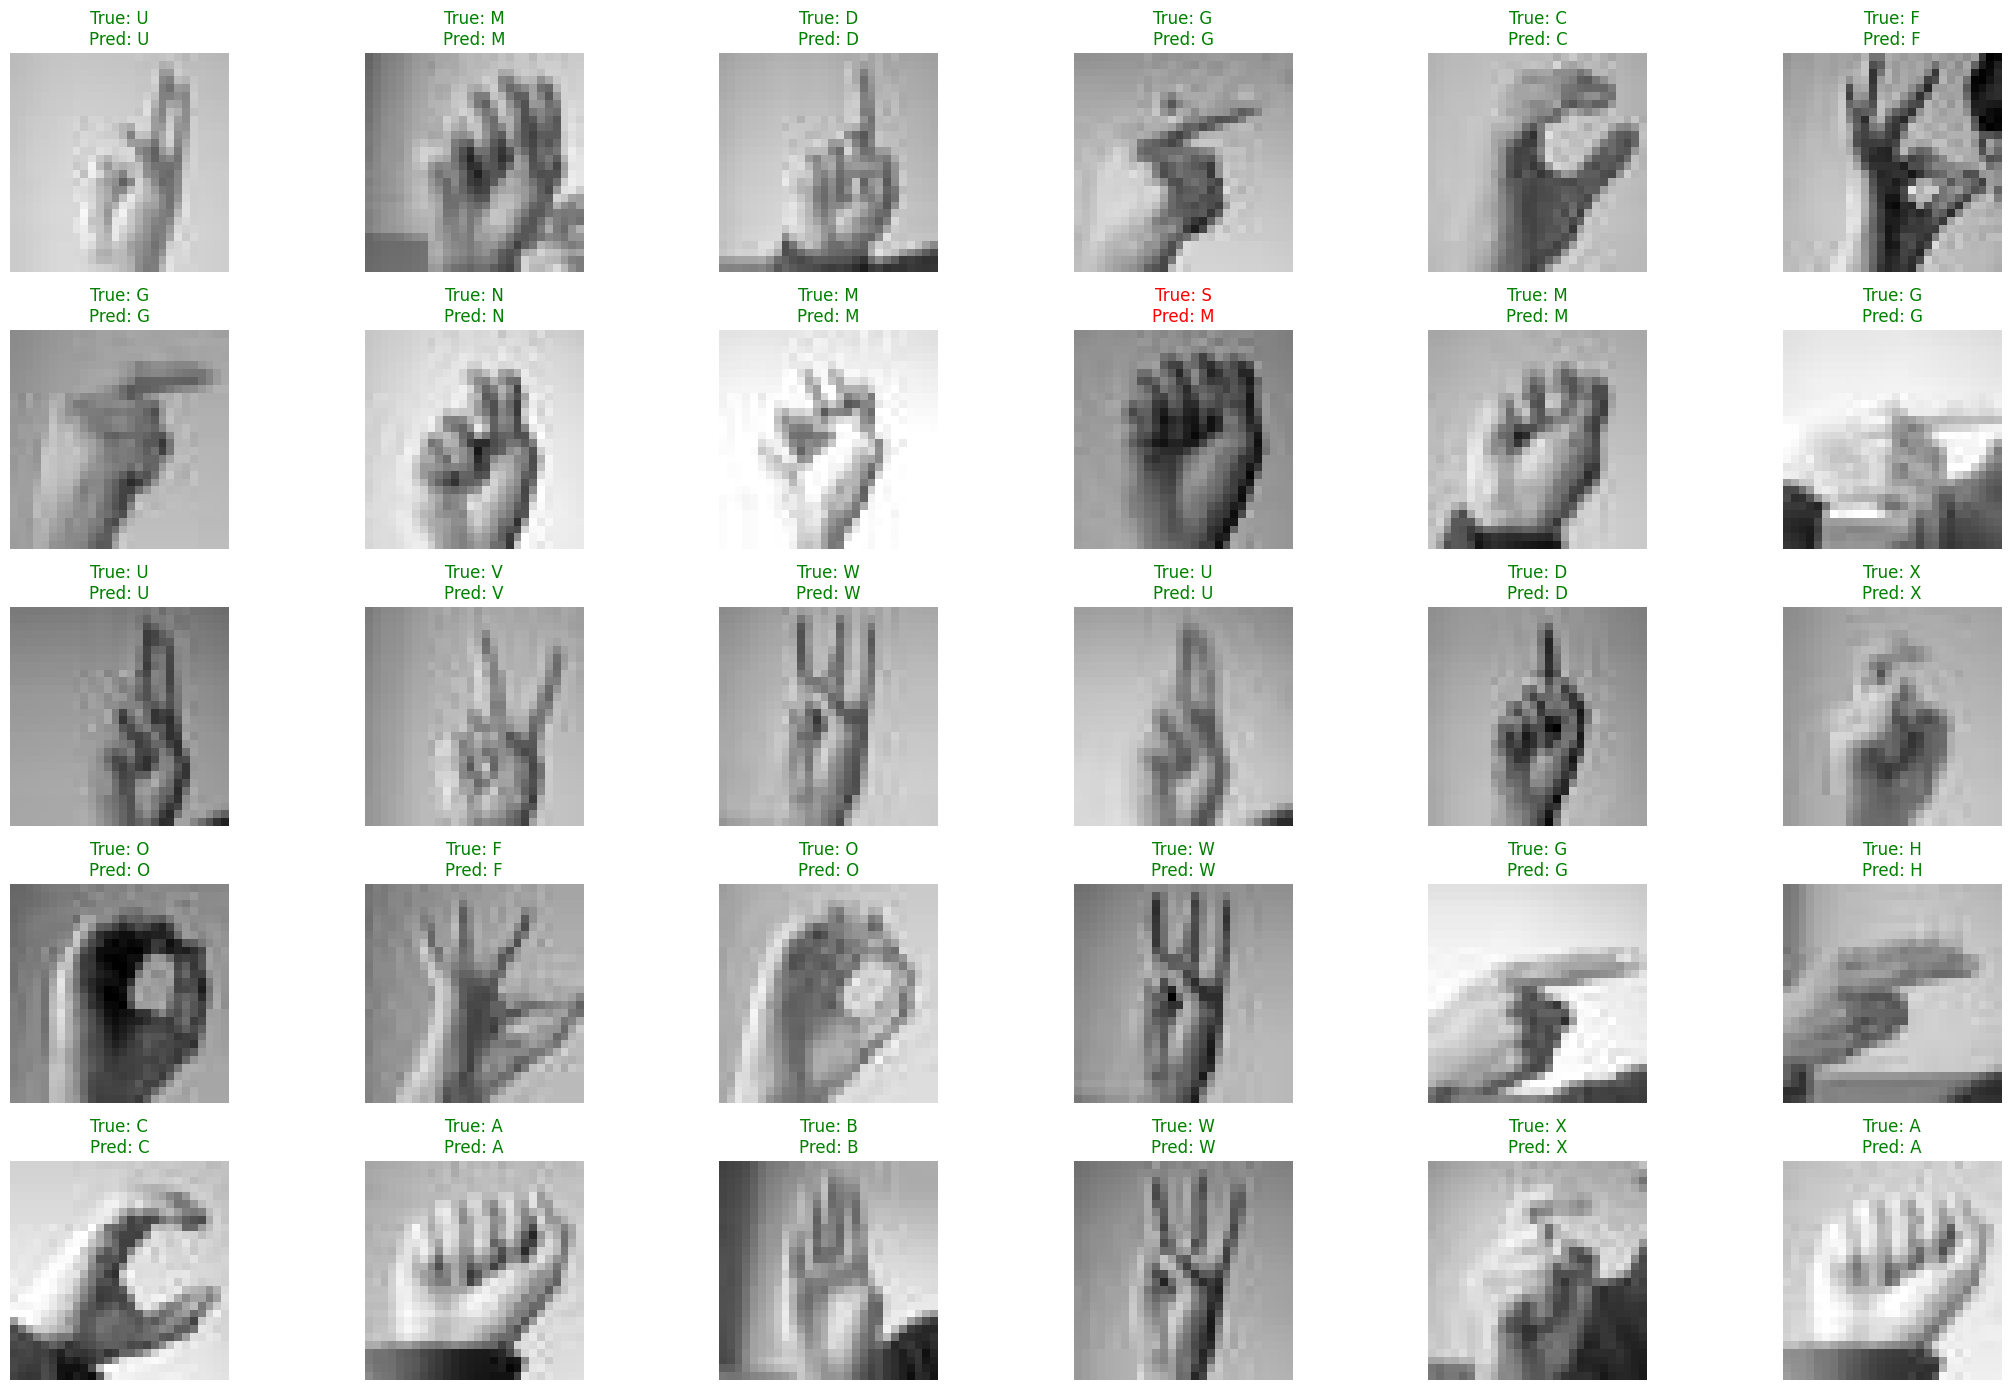

✅ Correct: 29 (96.67%)
❌ Wrong:   1 (3.33%)


In [ ]:
# Get class names from the generator
class_names = list(validation_generator.class_indices.keys())

# Grab a batch of validation images and labels
X_batch, y_batch = next(validation_generator)

# Predict on this batch
predictions = model.predict(X_batch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_batch, axis=1)

# Pick random images from the batch
num_images = 30
indices = np.random.choice(len(X_batch), num_images, replace=False)

# Counters
correct = 0
wrong = 0

plt.figure(figsize=(22, 14))

for i, idx in enumerate(indices):
    plt.subplot(5, 6, i + 1)   # 4 rows × 5 cols = 20 images

    img = X_batch[idx]

    # Show image (already scaled to [0,1])
    plt.imshow(img)
    plt.axis('off')

    # Labels
    true_label = class_names[true_classes[idx]]
    predicted_label = class_names[predicted_classes[idx]]

    # Check correctness
    if true_label == predicted_label:
        color = 'green'
        correct += 1
    else:
        color = 'red'
        wrong += 1

    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)

plt.tight_layout()
plt.show()

# Show statistics
total = correct + wrong
acc_percent = (correct / total) * 100
wrong_percent = (wrong / total) * 100

print("======"*25)
print(f"✅ Correct: {correct} ({acc_percent:.2f}%)")
print(f"❌ Wrong:   {wrong} ({wrong_percent:.2f}%)")

In [ ]:
model.save('model.h5')
print("Model saved successfully!")